In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score
from src.denoise_utils import denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style, VGG, VGG_dropout, VGG_noise
from src.datasets import StyleDataset, ArtistDataset
from src.train import train
from src.metric_utils import fid_metric, get_metric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from collections import deque
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob
import pickle

**FID**
- Comparison of max diversity and query set of samples
- Get distribution of FID vectors for each set + fit gaussian
- Frechet distance between gaussians

In [77]:
# ['max_div2','min_div','langevin','averagedim_all_r1000','ro3_all_r1000', 'cnn16_all_r1000','vgg_noise_all_r1000','vgg_noisero3_all_r1000']
exps = ['max_div2','min_div','eulera','langevin','averagedim_all_r1000','ro3_all_r1000', 'cnn16_all_r1000','vgg_noise_all_r1000','vgg_noisero3_all_r1000']
stats = {}
local = {}
gram64 = {}
for subject in ['actress','cave','kite','parkour','tree','vase']:
    for exp in exps:
        print(exp)
        metrics = fid_metric(exp,subject=subject,artistnum=-2)
        stats[subject, exp] = metrics['stats']
        local[subject, exp] = metrics['local']
        gram64[subject, exp] = metrics['gram64']

max_div2


min_div
eulera


/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.
Starting to sample.
Starting to sample.
langevin
averagedim_all_r1000
ro3_all_r1000
cnn16_all_r1000
vgg_noise_all_r1000
vgg_noisero3_all_r1000
max_div2
min_div
eulera
Starting to sample.
Starting to sample.
Starting to sample.
langevin
averagedim_all_r1000
ro3_all_r1000
cnn16_all_r1000
vgg_noise_all_r1000
vgg_noisero3_all_r1000
max_div2
min_div
eulera
Starting to sample.
Starting to sample.
Starting to sample.
langevin
averagedim_all_r1000
ro3_all_r1000
cnn16_all_r1000
vgg_noise_all_r1000
vgg_noisero3_all_r1000
max_div2
min_div
eulera
langevin
averagedim_all_r1000
ro3_all_r1000
cnn16_all_r1000
vgg_noise_all_r1000
vgg_noisero3_all_r1000
max_div2
min_div
eulera
Starting to sample.
Starting to sample.
Starting to sample.
langevin
averagedim_all_r1000
ro3_all_r1000
cnn16_all_r1000
vgg_noise_all_r1000
vgg_noisero3_all_r1000
max_div2
min_div
eulera
Starting to sample.
Starting to sample.
Starting to sample.
langevin
averagedim_all_r1000
ro3_all_r1000
cnn16_all_r1000
vgg_n

In [99]:
# Save this
import pickle
with open('data/final/stats_fid.pkl','wb') as f: 
    pickle.dump(stats, f)
with open('data/final/local_fid.pkl','wb') as f: 
    pickle.dump(local, f)
with open('data/final/gram64_fid.pkl','wb') as f: 
    pickle.dump(gram64, f)

In [5]:
# Load stats
with open('data/final/stats_fid.pkl','rb') as f: 
    stats = pickle.load(f)
with open('data/final/local_fid.pkl','rb') as f: 
    local = pickle.load(f)
with open('data/final/gram64_fid.pkl','rb') as f: 
    gram64 = pickle.load(f)

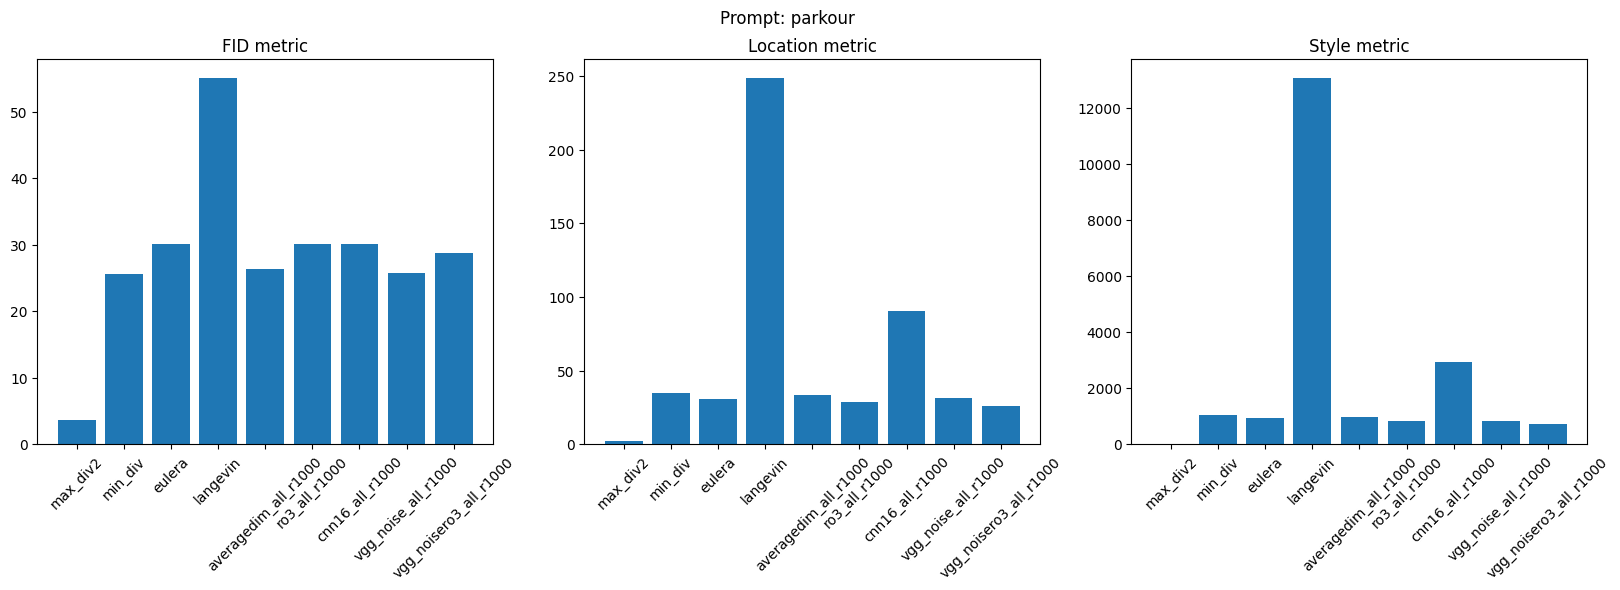

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
data = stats
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=45)
plt.title('FID metric')
plt.subplot(1,3,2)
data = local
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=45)
plt.title('Location metric')
plt.subplot(1,3,3)
data = gram64
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=45)
plt.title('Style metric')
plt.suptitle(f"Prompt: {subject}")
plt.show()


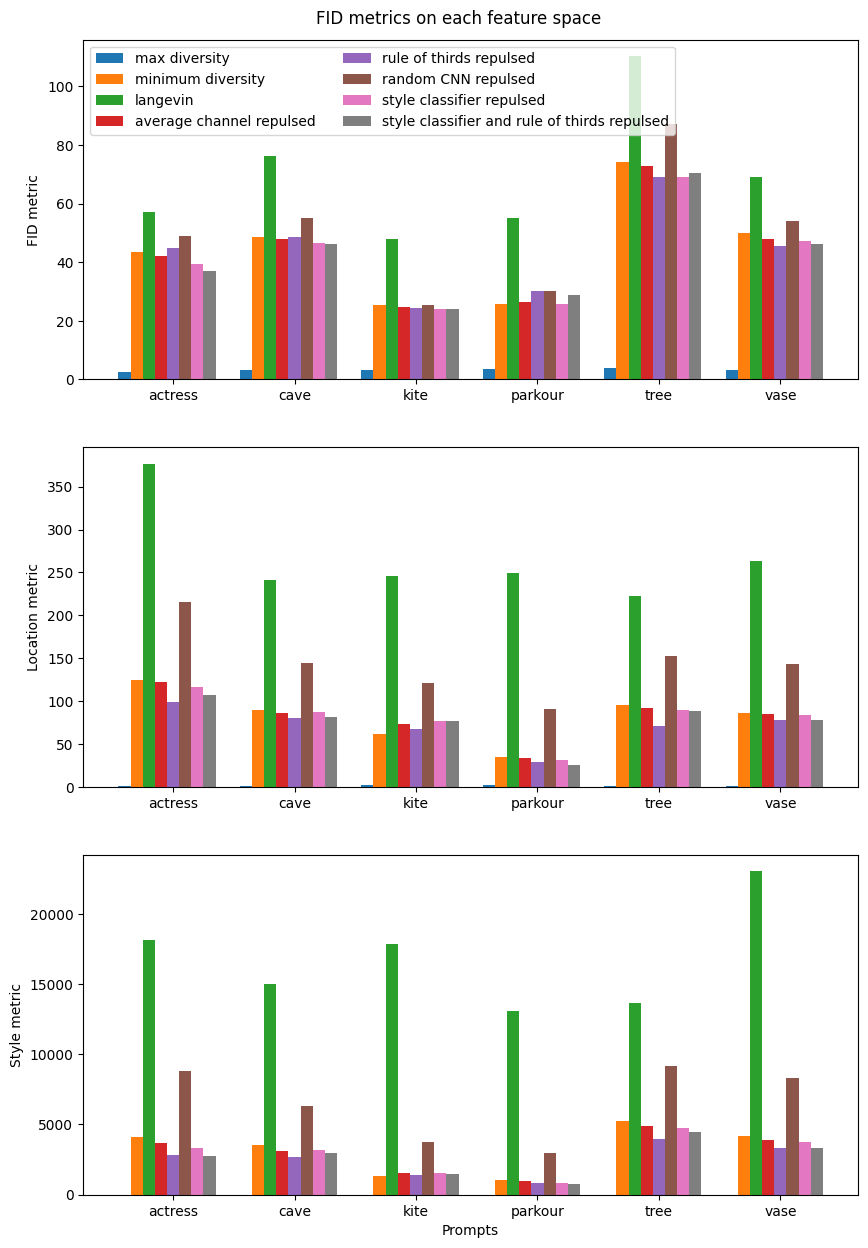

In [6]:
# Plot all FID metrics for all prompts
# methods are all separate colours, x axis is the prompt
exp_names = {
    'max_div2': 'max diversity',
    'min_div':'minimum diversity',
    'langevin': 'langevin',
    # 'eulera': 'stochastic scheduler',
    'averagedim_all_r1000': 'average channel repulsed',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
met_names = ['FID','Location','Style']
subjects = ['actress','cave','kite','parkour','tree','vase']
width=0.1
plt.figure(figsize=(10,15))

for i, data in enumerate([stats, local, gram64]):
    plt.subplot(3,1,i+1)
    for j, exp in enumerate(exp_names):
        values = []
        for subject in subjects:
            values.append(data[subject, exp])
        plt.bar(np.array(range(len(values))) + j*width, values, width, label=exp_names[exp])
    plt.xticks(np.array(range(len(values))) + len(exp_names)//2*width, subjects)#, rotation=45)
    plt.ylabel(f'{met_names[i]} metric')
    if i==0:
        plt.legend(loc='upper left', ncol=2)
    if i==2:
        plt.xlabel('Prompts')
plt.suptitle('FID metrics on each feature space', y=0.9)
plt.savefig('data/final/fid_plot.pdf')
plt.show()


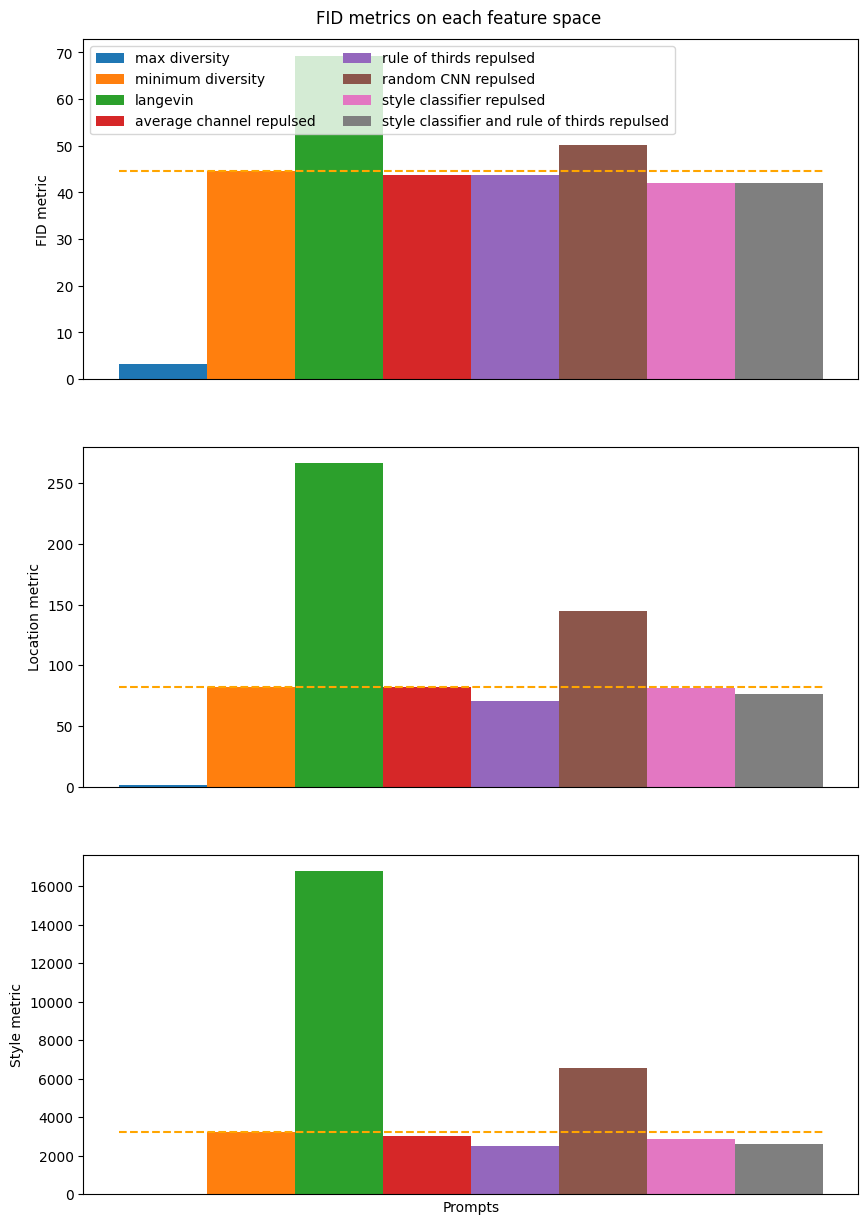

In [11]:
# Plot all FID metrics - AVERAGE OVER PROMPTS
# methods are all separate colours, x axis is the prompt
exp_names = {
    'max_div2': 'max diversity',
    'min_div':'minimum diversity',
    'langevin': 'langevin',
    # 'eulera': 'stochastic scheduler',
    'averagedim_all_r1000': 'average channel repulsed',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
met_names = ['FID','Location','Style']
subjects = ['actress','cave','kite','parkour','tree','vase']
width=1



plt.figure(figsize=(10,15))

for i, data in enumerate([stats, local, gram64]):
    ax = plt.subplot(3,1,i+1)
    min_div_val = 0
    for j, exp in enumerate(exp_names):
        value = 0
        for s, subject in enumerate(subjects):
            value += data[subject, exp]
        value /= len(subjects)
        if exp=="min_div":
            min_div_val = value
        plt.bar(j*width, value, width, label=exp_names[exp])
    plt.xticks([])
    # plt.xticks(len(exp_names)//2*width, subjects)#, rotation=45)
    plt.ylabel(f'{met_names[i]} metric')
    if i==0:
        plt.legend(loc='upper left', ncol=2)
    if i==2:
        plt.xlabel('Prompts')
    # ax.plot(0,2000,1,2000, secondary_y=True)
    # if exp=='min_div':
    # line = pd.DataFrame({'line' : [value]*len(exp_names)})
    # line['line'].plot(secondary_y=True)
    # plt.plot([value]*len(exp_names)
    plt.plot(np.array(range(len(exp_names)+1)) - 0.5, [min_div_val]*(len(exp_names)+1), '--', color='orange')
plt.suptitle('FID metrics on each feature space', y=0.9)
plt.savefig('data/final/fid_plot_average.pdf')

plt.show()

In [3]:
for exp_file in glob('data/final/cave/*/'):
    exp = os.path.basename(os.path.dirname(exp_file))
    if exp!='max_div':
        print(exp)
        print(fid_metric(exp))

max_div2
{'stats': 3.1619584465502157, 'local': 0.8060364672148523, 'gram64': 0.6090713574376423}
min_div
{'stats': 71.37755367342379, 'local': 8.685041981553198, 'gram64': 856.9077024221001}
averagedim_all_r10
{'stats': 71.02356331322824, 'local': 8.456937079276585, 'gram64': 814.0823104446572}
vggro3_all_r1000
{'stats': 68.17141354830105, 'local': 8.22528265592807, 'gram64': 859.7519633016946}
averagedim_all_r100
{'stats': 71.06855635677621, 'local': 8.59384055091813, 'gram64': 849.0034720353087}
ro3_all_r500
{'stats': 65.50791897882073, 'local': 7.894506363638868, 'gram64': 882.1449313092112}
cnn16_all_r500
{'stats': 71.79875445650177, 'local': 8.764678782291028, 'gram64': 798.5773165609694}
vgg_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
{'stats': 65.97050385508012, 'local': 7.7618890958351585, 'gram64': 745.340456734702}
vgg_dc_channel_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
{'stats': 64.42709019429765, 'local': 7.99611041147

In [7]:
# Read image sets
exp='max_div'
# f = []
# for file in glob(f"data/final/cave/{exp}/*/*.png"):
#     f.append(file)
f = []
for file in glob(f"data/final/cave/min_div/Thomas_Kinkade/*.png"):
    f.append(file)
for file in glob(f"data/final/cave/ro3_all_r1000/Thomas_Kinkade/*.png"):
    f.append(file)
for file in glob(f"data/final/cave/vgg_noise_all_r1000/Thomas_Kinkade/*.png"):
    f.append(file)

In [17]:
######### GET 2048 ACTIVATIONS
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 2048  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None)

# save_statistics(f"data/final/cave/{exp}_stats.npz",m,s)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [19]:
# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(act)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 1.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.610976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.726639
[t-SNE] KL divergence after 1000 iterations: 3.153918


/tmp/ipykernel_2513262/2593921330.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


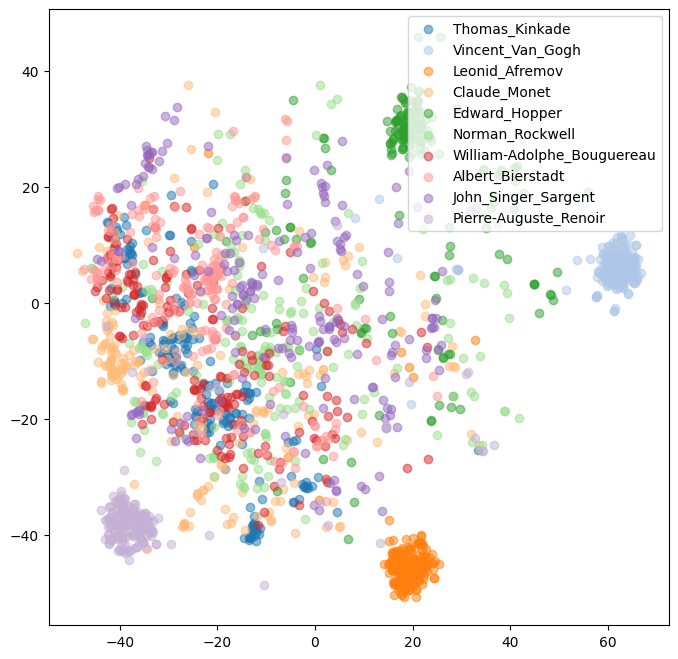

In [20]:
# Plotfor artists (max_div)
artists = []
for file in glob(f"data/final/cave/max_div/*/"):
    artist = os.path.basename(os.path.dirname(file))
    artists.append(artist)

# Plot those points as a scatter plot and label them based on the pred labels
from matplotlib import cm
num_categories = 10
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for i, artist in enumerate(artists):
    if i in range(0,0+num_categories):
        indices = np.zeros(len(tsne_proj))
        indices[i*200:(i+1)*200] = 1
        indices = indices==1
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(i)).reshape(1,4), label = artist ,alpha=0.5)
ax.legend()#fontsize='large', markerscale=2)
plt.show()

/tmp/ipykernel_2393904/3239418678.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


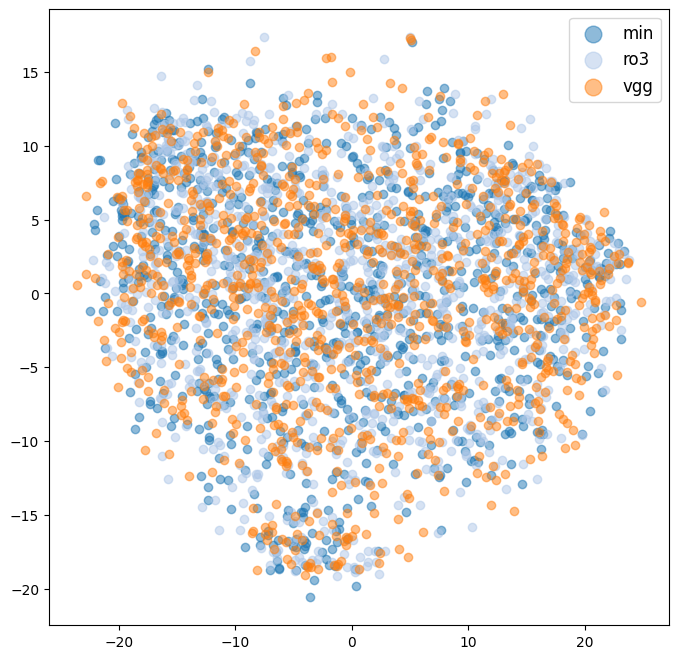

In [11]:
# Plot just one artist and different methods
from matplotlib import cm
# Plot those points as a scatter plot and label them based on the pred labels
# plt.figure(figsize=(20,20))
cats = ['min','ro3','vgg']
# cats=['vgg']
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for i, cat in enumerate(cats):
    indices = np.zeros(len(tsne_proj))
    indices[i*1000:(i+1)*1000] = 1
    indices = indices==1
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(i)).reshape(1,4), label = cat ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [43]:
m0, s0 = load_statistics("data/final/cave/max_div_stats.npz")
m, s = load_statistics(f"data/final/cave/{exp}_stats.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

65.50791897882073

Localisation diversity

In [21]:
## activations
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 192  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None)
# act = np.mean(act,axis=1)
# act = act.reshape(act.shape[0], -1)
# mu = np.mean(act, axis=0)
# sigma = np.cov(act, rowvar=False)
# save_statistics(f'data/final/cave/{exp}_local.npz',mu,sigma)


/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


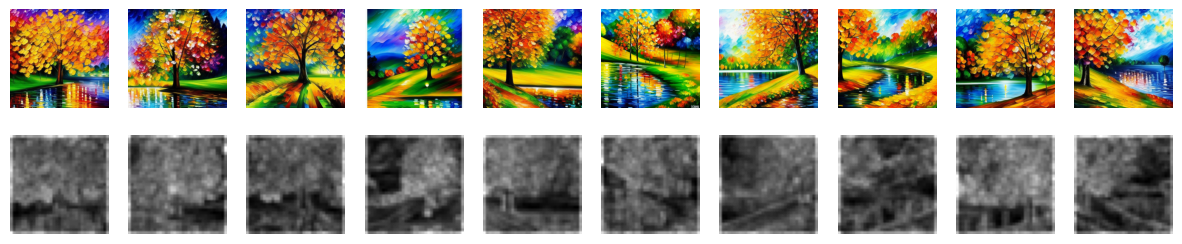

In [16]:
mean_act = np.mean(act,axis=1)
n=10
plt.figure(figsize=(15,3))
for i in range(n):
    img = Image.open(f[50+i])
    plt.subplot(2,n,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2,n,n + i + 1)
    plt.imshow(mean_act[50+i], cmap='gray')
    plt.axis('off')
# plt.savefig("figures/inceptionfeatures.pdf")

In [46]:
# Get FID of each artist's images
for f in glob("data/styles/artists/*"):
    imgs = []
    for imgf in glob(f"{f}/*.png"):
        imgs.append(imgf)
    print(len(imgs))
    m, s = calculate_activation_statistics(imgs, model, 8, dims, device)
    save_statistics(f"{f}/fid.npz",m,s)

In [47]:
m0, s0 = load_statistics("data/final/cave/max_div_local.npz")
m, s = load_statistics(f"data/final/cave/{exp}_local.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

7.894506363638868

Style diversity


In [69]:
exp='max_div'
f = []
for file in glob(f"data/final/vase/{exp}/*/*.png"):
    f.append(file)

In [12]:
## activations
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 64  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None, gap=True)
gram = np.einsum('ni,nj->nij',act,act)
# Flattened upper triangular 
sims = []
for i in range(len(gram)):
    sim = gram[i][np.triu_indices(dims)]
    sims.append(sim)
sims = np.stack(sims)
# mu = np.mean(sims, axis=0)
# sigma = np.cov(sims, rowvar=False)
# save_statistics(f'data/final/cave/{exp}_gram64.npz',mu,sigma)

Starting to sample.


In [13]:
def spread(a,b):
    # Given 2 sets of vectors, return the 
    s=0
    cnt=0
    for i in range(len(a)):
        for j in range(len(b)):
            s += np.linalg.norm(a[i]-b[j])
            cnt+=1
    return s/cnt

In [78]:
# Get spread of sims within style and between styles
feat=act
# Get L2 distances between particles

n = 200
l2_mat = np.zeros((50,50))
for style_i in range(50):
    for style_j in range(style_i, 50):
        i=n*style_i
        j=n*style_j
        s = spread(feat[i:i+n],feat[j:j+n])
        l2_mat[style_i,style_j] = s
        l2_mat[style_j,style_i] = s
        # print(f"Style {style_i}-{style_j} spread:",s)

In [79]:
# Save spread matrix for plotting later
# style_spread_sims is the average l2 distance between vectors between artists for gram64 features (act is for 2048 features)
np.savez('data/metrics/style_spread_act_vase.npz', m=l2_mat)

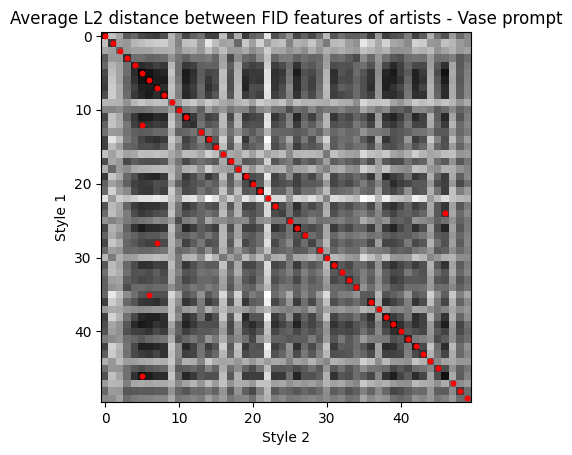

In [82]:
# Plot style features spread between artists
min_idx = np.argmin(l2_mat,axis=0)
correct_idx = np.sum(min_idx == np.array(range(50)))
plt.scatter(min_idx, list(range(50)), color='r',s=10)
plt.imshow(l2_mat,cmap='gray')
plt.scatter
plt.ylabel('Style 1')
plt.xlabel('Style 2')
plt.title('Average L2 distance between FID features of artists - Vase prompt')
plt.show()

In [83]:
np.sum(correct_idx)

45

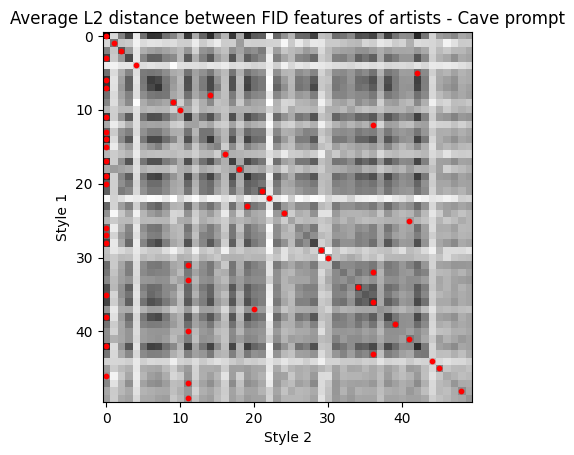

In [49]:
# Plot style features spread between artists
min_idx = np.argmin(l2_act_mat,axis=0)
correct_idx = np.sum(min_idx == np.array(range(50)))
plt.scatter(min_idx, list(range(50)), color='r',s=10)
plt.imshow(l2_act_mat,cmap='gray')
plt.scatter
plt.ylabel('Style 1')
plt.xlabel('Style 2')
plt.title('Average L2 distance between FID features of artists - Cave prompt')
plt.show()

In [36]:
min_idx = np.argmin(l2_act_mat,axis=0)
np.sum(min_idx == np.array(range(50)))

20

In [49]:
m0, s0 = load_statistics("data/final/cave/max_div_gram64.npz")
m, s = load_statistics(f"data/final/cave/{exp}_gram64.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

882.1449313092112

In [50]:
# Plot images from dataset
import glob
n=2
images = []
for folder in glob.glob("data/fruit/*"):
    i=0
    for file in glob.glob(os.path.join(folder,"*")):
        if i<n:
            images.append(Image.open(file))
            i+=1

grid = image_grid(images, rows=n, cols=10)



Checking metrics work

In [2]:
# 2 images with very similar location and style, and one with same location but different style
f = ['data/outputs/out_repulsive_averagedim_2023-06-08_221845/out_repulsive_averagedim_2023-06-08_221845_4.png', # loc 1, style 1
        'data/outputs/out_repulsive_averagedim_2023-06-08_221845/out_repulsive_averagedim_2023-06-08_221845_6.png', # loc 1, style 1
        'data/outputs/out_repulsive_averagedim_2023-06-08_221845/out_repulsive_averagedim_2023-06-08_221845_15.png', # loc 1, style 2
        'data/outputs/out_repulsive_averagedim_2023-06-08_221845/out_repulsive_averagedim_2023-06-08_221845_14.png'] # loc 2, style 2

In [23]:
act = get_metric(f, 'gram64', return_act=True)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


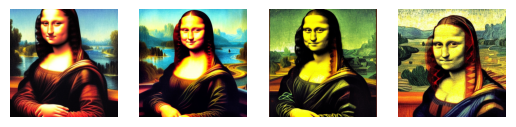

In [8]:
for i,file in enumerate(f):
    plt.subplot(1,len(f),i+1)
    img = plt.imread(file)
    plt.imshow(img)
    plt.axis('off')

In [37]:
for met in ['stats','gram64','local']:
    print(met)
    act = get_metric(f, met, return_act=True)
    print('Loc1 style 1 - loc1 style1')
    print(spread(act[0,None],act[1,None]))
    print('Loc1 style1 - loc1 style2')
    print(spread(act[0:2],act[2,None]))
    print('Loc1 style1 - loc2 style2')
    print(spread(act[0:2],act[3,None]))
    print('Loc1 style2 - loc2 style2')
    print(spread(act[2,None],act[3,None]))

stats


/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.
Loc1 style 1 - loc1 style1
10.457611083984375
Loc1 style1 - loc1 style2
15.41372013092041
Loc1 style1 - loc2 style2
16.87619161605835
Loc1 style2 - loc2 style2
14.595402717590332
gram64
Starting to sample.
Loc1 style 1 - loc1 style1
24.8236026763916
Loc1 style1 - loc1 style2
52.12331199645996
Loc1 style1 - loc2 style2
77.72181701660156
Loc1 style2 - loc2 style2
58.73518371582031
local
Starting to sample.
Loc1 style 1 - loc1 style1
17.65671730041504
Loc1 style1 - loc1 style2
16.25394058227539
Loc1 style1 - loc2 style2
18.508248329162598
Loc1 style2 - loc2 style2
19.005924224853516


In [8]:
f

['data/outputs/birds/bird2.png',
 'data/outputs/birds/bird3.png',
 'data/outputs/birds/bird4.png',
 'data/outputs/birds/bird5.png',
 'data/outputs/birds/bird6.png',
 'data/outputs/birds/bird7.png',
 'data/outputs/birds/bird8.png',
 'data/outputs/birds/bird9.png',
 'data/outputs/birds/bird1.png']

In [9]:
# images with same style, but subject moves along image
f = []
for i in range(9):
    f.append(f'data/metrics/birds/bird{i+1}.png')
for met in ['stats','gram64','local']:
    print(met)
    act = get_metric(f, met, return_act=True)
    for i in range(9):
        for j in range(i,9):
            print(f"dist {i}-{j}:", np.linalg.norm(act[i]-act[j]))

stats


/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.
dist 0-0: 0.0
dist 0-1: 7.545343
dist 0-2: 7.399714
dist 0-3: 7.7884197
dist 0-4: 11.6161785
dist 0-5: 9.602798
dist 0-6: 11.2313175
dist 0-7: 10.057007
dist 0-8: 9.930873
dist 1-1: 0.0
dist 1-2: 6.414066
dist 1-3: 6.901241
dist 1-4: 9.043955
dist 1-5: 7.0758147
dist 1-6: 10.934274
dist 1-7: 7.396311
dist 1-8: 9.0714855
dist 2-2: 0.0
dist 2-3: 7.1896467
dist 2-4: 9.311702
dist 2-5: 7.412047
dist 2-6: 9.985672
dist 2-7: 8.017478
dist 2-8: 7.910712
dist 3-3: 0.0
dist 3-4: 7.813046
dist 3-5: 6.7524033
dist 3-6: 8.900935
dist 3-7: 7.8842397
dist 3-8: 8.049531
dist 4-4: 0.0
dist 4-5: 7.8785815
dist 4-6: 9.991969
dist 4-7: 8.898452
dist 4-8: 10.260955
dist 5-5: 0.0
dist 5-6: 9.163524
dist 5-7: 6.1580515
dist 5-8: 8.250635
dist 6-6: 0.0
dist 6-7: 10.249867
dist 6-8: 8.2868805
dist 7-7: 0.0
dist 7-8: 8.849216
dist 8-8: 0.0
gram64
Starting to sample.
dist 0-0: 0.0
dist 0-1: 0.15808617
dist 0-2: 0.15121725
dist 0-3: 0.16487467
dist 0-4: 0.18774362
dist 0-5: 0.16850315
dist 0-

In [79]:
f=[]
for file in glob('/home/ap2619/particlediffusion/data/metrics/birds/tbird_b/*'):
    f.append(file)
    if len(f)==10:
        break

In [80]:
act_local = get_metric(f, 'local', return_act=True)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [61]:
mean_act = np.mean(act_local,axis=1)

In [43]:
(act_local>mean_act[:,None,...]).shape

(10, 192, 35, 35)

In [62]:
total_thresh_act = np.sum(act_local>mean_act[:,None,...],axis=1)

In [44]:
(mean_act>0.9*np.max(mean_act)).shape

(10, 35, 35)

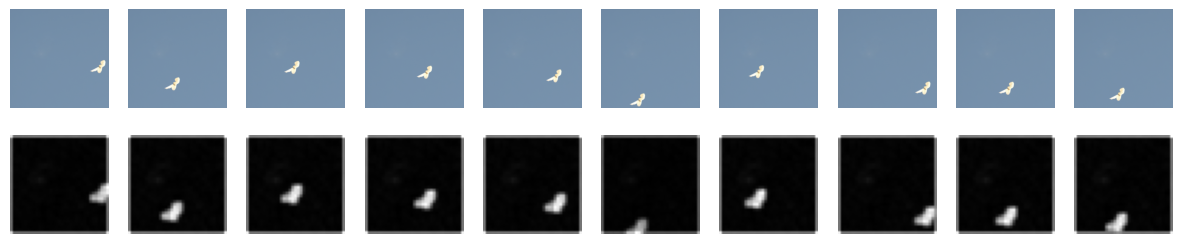

In [78]:
# act = get_metric(f, 'local', return_act=True)
act = mean_act #mean_act * (mean_act>0.5*np.max(mean_act))
n=10
plt.figure(figsize=(15,3))
for i in range(n):
    img = Image.open(f[i])
    plt.subplot(2,n,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2,n,n + i + 1)
    plt.imshow(act[i], cmap='gray')
    plt.axis('off')
# plt.savefig("figures/inceptionfeatures.pdf")

In [83]:
# Getting 10k placements in top left part, 10k placements in bottom right part for bird
for i in range(10000):
    # Top placement
    dst_path = f'data/metrics/birds/bird2_t'
    bird = Image.open(f'data/metrics/birds/tbird.png')
    background = Image.open(f'data/metrics/birds/background.png')
    loc_x = np.random.randint(0,background.size[0]-bird.size[0])
    loc_y = np.random.randint(0,background.size[1]//2 - bird.size[0])
    background.paste(bird, (loc_x,loc_y), mask=bird)
    background.save(os.path.join(dst_path, f'bird2_t_{i}.png'))

    # Bottom placement
    dst_path = f'data/metrics/birds/bird2_b'
    bird = Image.open(f'data/metrics/birds/tbird.png')
    background = Image.open(f'data/metrics/birds/background.png')
    loc_x = np.random.randint(0,background.size[0]-bird.size[0])
    loc_y = np.random.randint(background.size[1]//2,background.size[1]-bird.size[1])
    background.paste(bird, (loc_x,loc_y), mask=bird)
    background.save(os.path.join(dst_path, f'bird2_b_{i}.png'))

        


In [84]:
# Get metrics m,s for each subset
for pre in ['']:
    for side in ['b','t']:
        f = []
        for file in glob(f'data/metrics/birds/{pre}bird2_{side}/*'):
            f.append(file)
        for met in ['stats','gram64','local']:
            m,s = get_metric(f, met)
            save_statistics(f'data/metrics/birds/{pre}bird2_{side}_{met}.npz',m,s)

Starting to sample.
Starting to sample.
Starting to sample.
Starting to sample.
Starting to sample.
Starting to sample.


In [5]:
# Display FID scores
for met in ['stats','gram64','local']:
    print(met)
    # Load all m,s
    m0,s0 = load_statistics(f'data/metrics/birds/bird_b_{met}.npz')
    m,s = load_statistics(f'data/metrics/birds/bird2_t_{met}.npz')
    # compare each pair with fid
    fid = calculate_frechet_distance(m, s, m0, s0)
    print(fid)

stats


236.66903162186878
gram64
3.8664460263300144
local
128.47928458545027


In [7]:
# Plot birds



(151, 61)

Sorting by feature vector

In [177]:
# TODO: Get min localisation/style pairs in max_div i.e. closest images in location and style
prompt='vase'
exp='min_div'
met = 'gram64'
exp_names = {
    'max_div': 'max diversity',
    'min_div':'minimum diversity',
    'averagedim_all_r1000':'average channel repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'langevin': 'langevin',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
met_names = {
    'stats': 'FID',
    'gram64': 'Style',
    'local': 'Location'
}
os.makedirs(f'data/final/{prompt}/plots/', exist_ok=True)
for exp in exp_names:
    for met in met_names:
        f = []
        for file in glob(f"data/final/{prompt}/{exp}/*/*.png"):
            f.append(file)
        # Get metric features
        act = get_metric(f, met, return_act=True)
        # Get sorted distance pairs
        dists = {}
        for i in range(n):
            for j in range(i+1,n):
                d = np.linalg.norm(act[i]-act[j])
                dists[i,j] = d
        dists_sorted = sorted(dists.items(), key=lambda x:x[1])

        n=5
        n_rows=2
        n_cols=n*2
        wspace = 0.6
        fig = plt.figure(figsize=(10,1.6), dpi=300)
        for i in range(n):
            # Most similar
            p_i, p_j = dists_sorted[i][0]
            # print(dists_sorted[i][1])
            f_i = f[p_i]
            f_j = f[p_j]
            ax = plt.subplot(n_rows,n_cols,i+1)
            plt.imshow(plt.imread(f_i))
            plt.subplots_adjust(hspace=0.1, wspace=wspace)
            plt.xticks([])
            plt.yticks([])
            ax = plt.subplot(n_rows,n_cols,n_cols+i+1)
            plt.imshow(plt.imread(f_j))
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(hspace=0.1, wspace=wspace)
            plt.xlabel(str(round(dists_sorted[i][1],2)))
        for i in range(-n,0):
            # Least similar
            p_i, p_j = dists_sorted[i][0]
            # print(dists_sorted[-1-i][1])
            f_i = f[p_i]
            f_j = f[p_j]
            ax = plt.subplot(n_rows,n_cols,i+2*n+1)
            plt.imshow(plt.imread(f_i))
            plt.subplots_adjust(hspace=0.1, wspace=wspace)
            plt.xticks([])
            plt.yticks([])
            ax = plt.subplot(n_rows,n_cols,n_cols+i+2*n+1)
            plt.imshow(plt.imread(f_j))
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(hspace=0.1, wspace=wspace)
            plt.xlabel(str(round(dists_sorted[i][1],2)))

        plt.suptitle(f'{met_names[met]} feature L2 distance pairs - {exp_names[exp]} set')
        plt.show()
        dst = f'data/final/{prompt}/plots/{exp}_{met}_dists.pdf'
        plt.savefig(dst)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


Exception ignored in: <function _releaseLock at 0x7f70e23a6290>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


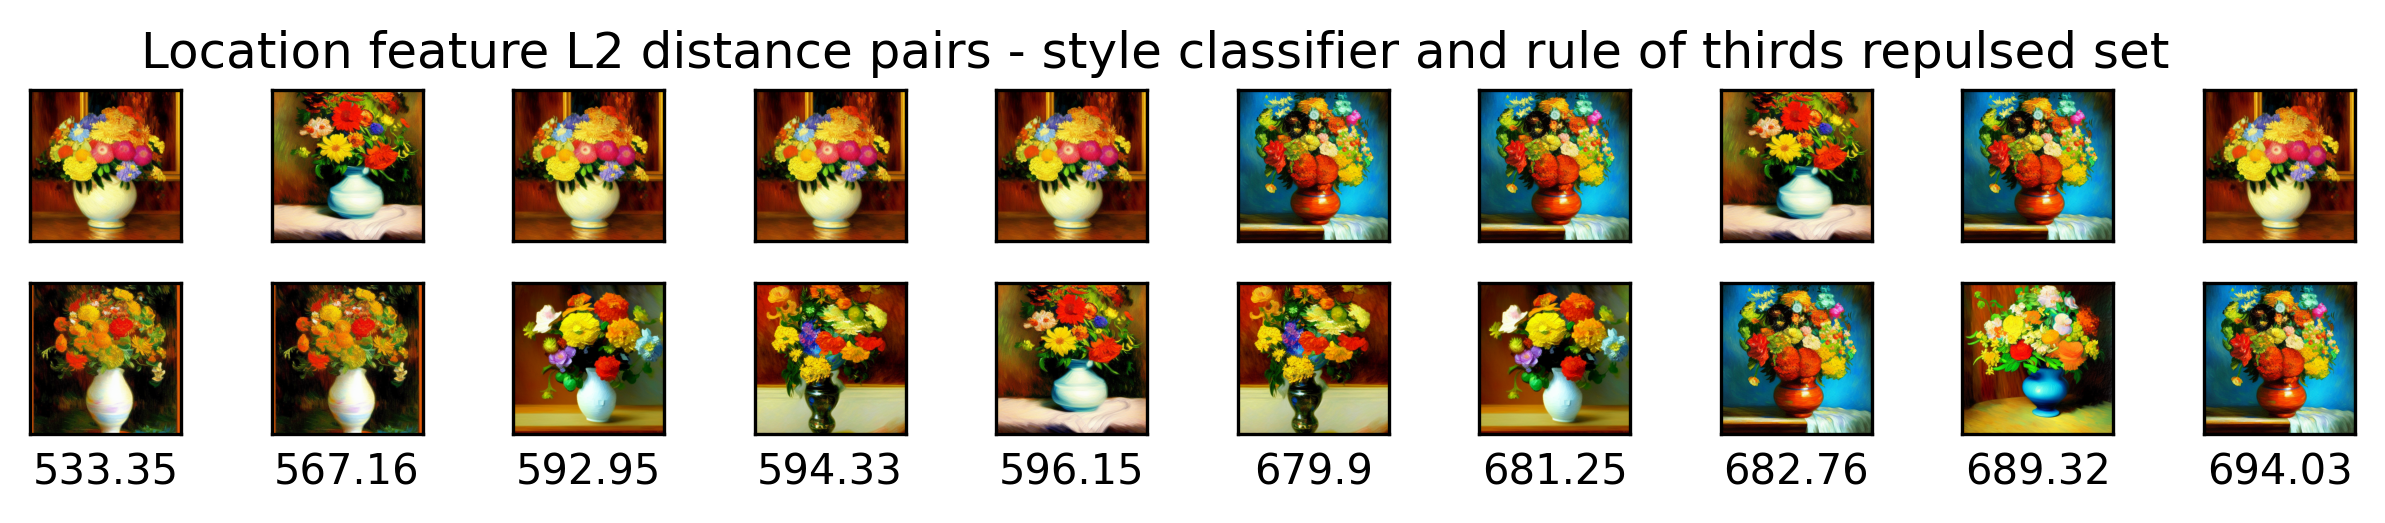

In [176]:
# i=1
n=5
n_rows=2
n_cols=n*2
wspace = 0.6
fig = plt.figure(figsize=(10,1.6), dpi=300)
for i in range(n):
    # Most similar
    p_i, p_j = dists_sorted[i][0]
    # print(dists_sorted[i][1])
    f_i = f[p_i]
    f_j = f[p_j]
    ax = plt.subplot(n_rows,n_cols,i+1)
    plt.imshow(plt.imread(f_i))
    plt.subplots_adjust(hspace=0.1, wspace=wspace)
    plt.xticks([])
    plt.yticks([])
    ax = plt.subplot(n_rows,n_cols,n_cols+i+1)
    plt.imshow(plt.imread(f_j))
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0.1, wspace=wspace)
    plt.xlabel(str(round(dists_sorted[i][1],2)))
for i in range(-n,0):
    # Least similar
    p_i, p_j = dists_sorted[i][0]
    # print(dists_sorted[-1-i][1])
    f_i = f[p_i]
    f_j = f[p_j]
    ax = plt.subplot(n_rows,n_cols,i+2*n+1)
    plt.imshow(plt.imread(f_i))
    plt.subplots_adjust(hspace=0.1, wspace=wspace)
    plt.xticks([])
    plt.yticks([])
    ax = plt.subplot(n_rows,n_cols,n_cols+i+2*n+1)
    plt.imshow(plt.imread(f_j))
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0.1, wspace=wspace)
    plt.xlabel(str(round(dists_sorted[i][1],2)))

plt.suptitle(f'{met_names[met]} feature L2 distance pairs - {exp_names[exp]} set')
plt.show()
dst = f'data/final/{prompt}/plots/{exp}_{met}_dists.pdf'
plt.savefig(dst)

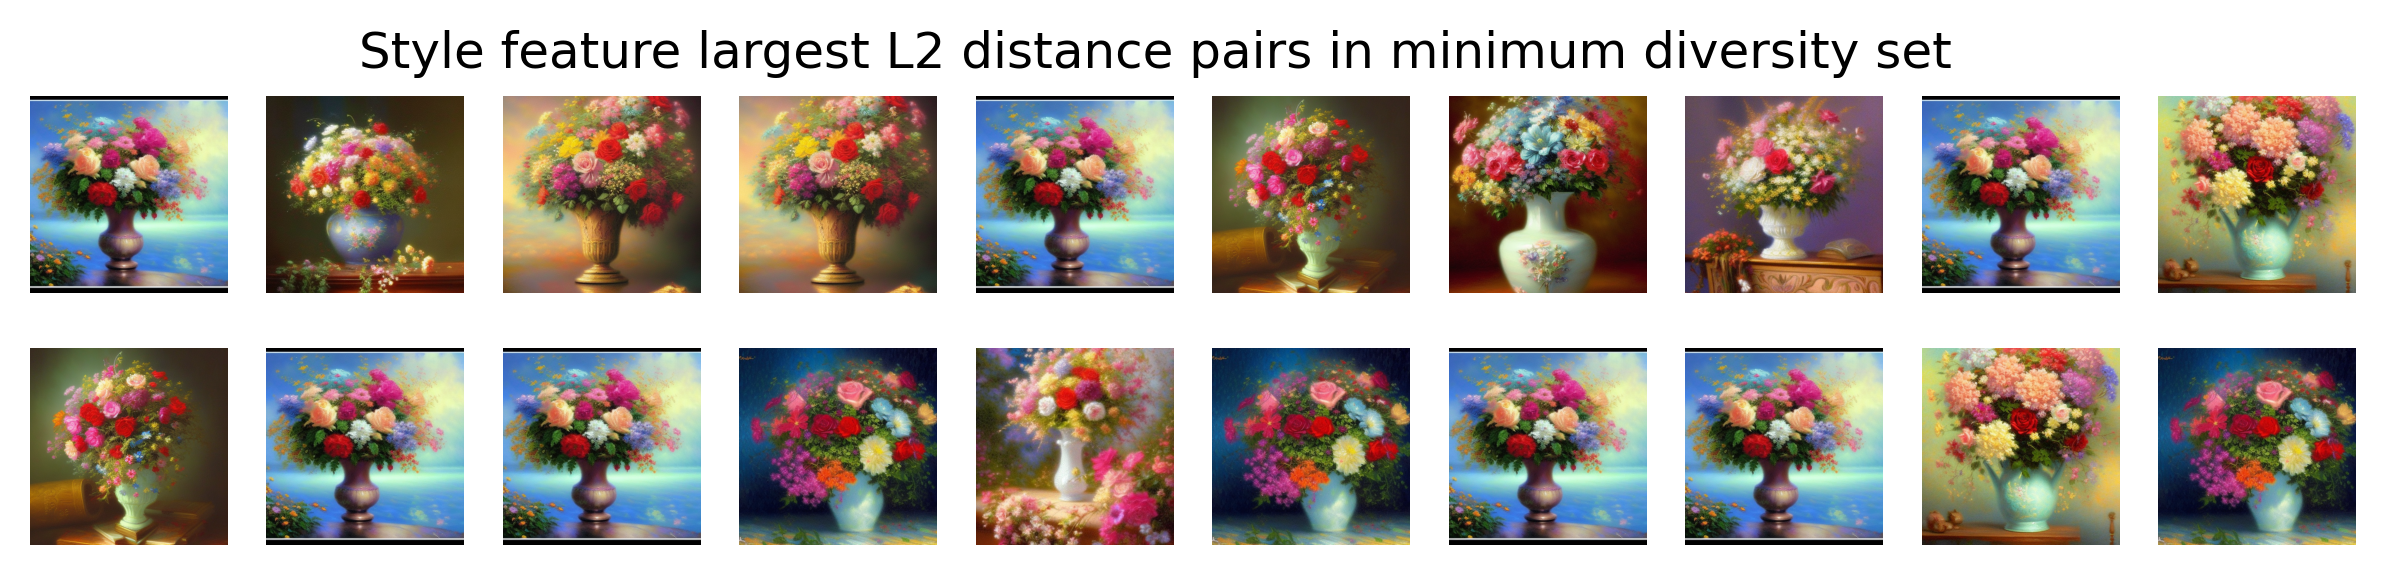

In [101]:
# i=1
n=10
n_rows=2
n_cols=n
plt.figure(figsize=(10,2), dpi=300)
for i in range(n):
    # Least similar
    p_i, p_j = dists_sorted[-1-i][0]
    # print(dists_sorted[-1-i][1])
    f_i = f[p_i]
    f_j = f[p_j]
    plt.subplot(n_rows,n_cols,i+1)
    plt.imshow(plt.imread(f_i))
    plt.axis('off')
    plt.subplot(n_rows,n_cols,n+i+1)
    plt.imshow(plt.imread(f_j))
    plt.axis('off')

plt.suptitle(f'{met_names[met]} feature largest L2 distance pairs in {exp_names[exp]} set')
dst = f'data/final/{prompt}/plots/{exp}_{met}_max_dists.pdf'
os.makedirs(dst, exist_ok=True)
plt.savefig(dst)

Eigen spectrum

In [116]:
prompt='cave'
exp='min_div'
met = 'stats'
exp_names = {
    'max_div': 'max diversity',
    'min_div':'minimum diversity',
    'averagedim_all_r1000':'average channel repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'langevin': 'langevin',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
met_names = {
    'stats': 'FID',
    'gram64': 'Style',
    'local': 'Location'
}
f = []
for file in glob(f"data/final/{prompt}/{exp}/all/*.png"):
    f.append(file)
# Get metric features
act = get_metric(f, met, return_act=True)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [5]:
w, v = np.linalg.eig(act @ act.T)

In [14]:
import scipy
w_noisero3, v_vgg_noise = scipy.sparse.linalg.eigs(act @ act.T, k=50)

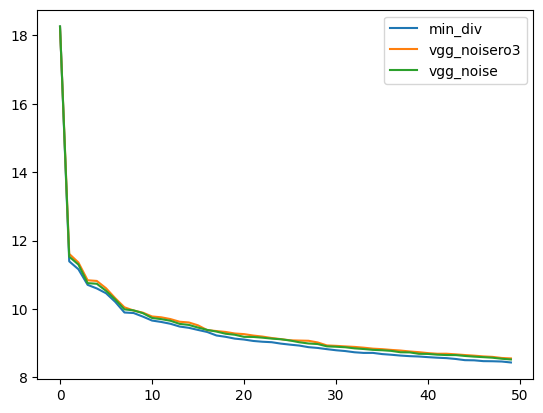

In [18]:
n=50
plt.plot(np.log(w_min_div[:n]), label='min_div')
plt.plot(np.log(w_noisero3[:n]), label='vgg_noisero3')
# plt.plot(np.log(w_langevin[:n]), label='langevin')
# plt.plot(np.log(w_max_div[:n]), label='max_div')
plt.plot(np.log(w_vgg_noise[:n]), label='vgg_noise')
plt.legend()

HISTOGRAMS

In [48]:
n=len(act)
dists = {}
for i in range(n):
    for j in range(i+1,n):
        d = np.linalg.norm(act[i]-act[j])
        dists[i,j] = d
dists_sorted = sorted(dists.items(), key=lambda x:x[1])

In [34]:
import pickle
with open('/home/ap2619/particlediffusion/data/final/cave/metrics_all/max_div_stats_dists.pkl','wb') as f: 
    pickle.dump(dists_sorted, f)

In [117]:
with open('/home/ap2619/particlediffusion/data/final/cave/metrics_all/min_div_stats_dists.pkl','rb') as f: 
    dists_sorted = pickle.load(f)

In [118]:
from sklearn.metrics.pairwise import euclidean_distances
d = euclidean_distances(act, act)

In [123]:
d_sorted = sorted(dists.items(), key=lambda x:x[1])

In [49]:
dists_only = [d[1] for d in dists_sorted]

Text(0, 0.5, 'Frequency')

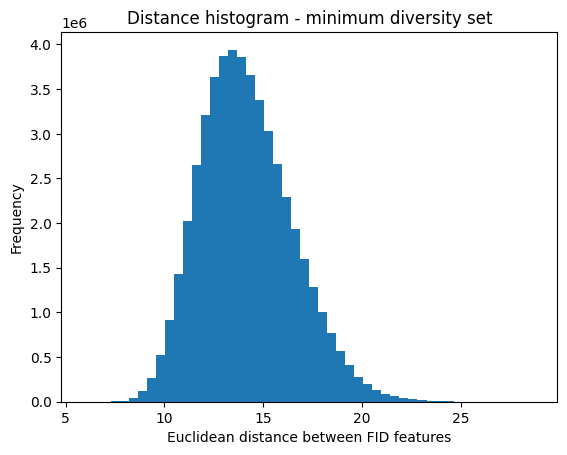

In [54]:
plt.hist(dists_only, bins=5)
plt.title(f'Distance histogram - {exp_names[exp]} set')
plt.xlabel(f'Euclidean distance between {met_names[met]} features')
plt.ylabel('Frequency')
plt.xticks([0,4])
plt.yaxis

histograms (exp)

In [143]:
import pickle
all_hists = {}

met = "local"
met_name = "Location"
exp_names = {
    'max_div': 'max diversity',
    'min_div':'minimum diversity',
    'langevin': 'langevin',
    # 'eulera': 'stochastic scheduler',
    'averagedim_all_r1000': 'average channel repulsed',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
prompts = ['actress','cave','kite','parkour','tree','vase']
mets = ['stats','local','gram64']
met_names = ['FID','Location','Style']
for prompt in prompts:
    for i, met in enumerate(mets):
        hists = {}
        met_name = met_names[i]
        for exp in exp_names:
            with open(f'data/final/{prompt}/metrics_all/{exp}_{met}_dists.pkl','rb') as f: 
                dists_sorted = pickle.load(f)
            hists[exp] = [d[1] for d in dists_sorted]
        all_hists[prompt, met] = hists

In [14]:
kwargs = dict(histtype='stepfilled', alpha=0.4, bins=50)

In [163]:
# hists = all_hists['actress','local']
all_n_bins = {}

for prompt in prompts:
    for i, met in enumerate(mets):
        nbins= 200
        hists = all_hists[prompt, met]
        if met=="stats":
            ubound=31
        elif met=="gram64":
            ubound=240
        elif met=="local":
            ubound=40
        # ubound = max(hists[exp])
        bins = np.linspace(0,ubound, nbins)
        width = bins[1]-bins[0]
        n_bins = {}
        for exp in exp_names:
            n, _ = np.histogram(hists[exp], bins=bins)
            n_bins[exp] = n
        all_n_bins[prompt, met] = n_bins

In [76]:
for exp in exp_names:
    print(max(hists[exp]))

33.215816
29.277922
33.068813
31.594357
31.723263
36.37883
37.32076
38.04841
39.168743


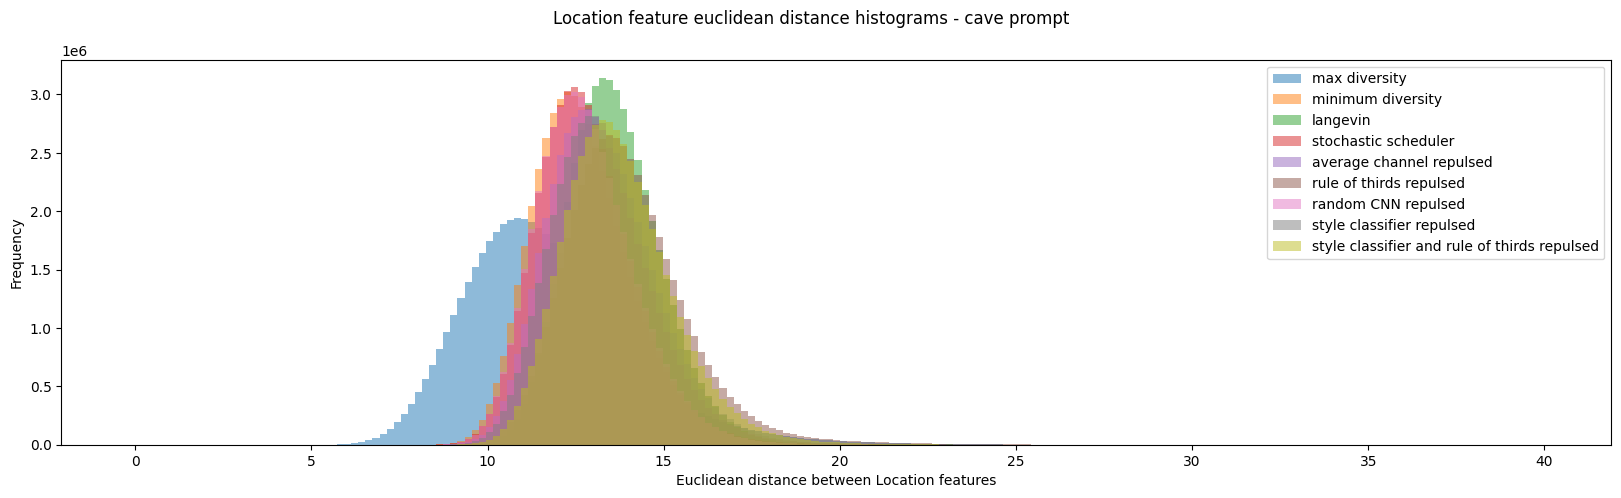

In [21]:
# OVERLAP HISTOGRAM
plt.figure(figsize=(20,5))
for exp in exp_names:
    plt.bar(bins[:-1],n_bins[exp],width=width, alpha=0.5, label=exp_names[exp])
plt.legend()
plt.xlabel(f'Euclidean distance between {met_name} features')
plt.ylabel('Frequency')
plt.suptitle(f'{met_name} feature euclidean distance histograms - cave prompt')
plt.savefig(f'data/final/cave/plots/cave_hist_overlap_{met}.pdf')
plt.show()

In [ ]:
# DISTANCE HISTOGRAM 

iqrs = {}
ranges = {}
# subject="cave"
# met="gram64"
# met_name = "Style"
for subject in subjects:
    for m, met in enumerate(mets):
        met_name = met_names[m]
        n_bins = all_n_bins[subject, met]
        hists = all_hists[subject, met]

        plt.figure(figsize=(20,1*len(exp_names)))
        colors = plt.rcParams["axes.prop_cycle"]()
        for i, exp in enumerate(exp_names):
            plt.subplot(len(exp_names),1,i+1)
            c = next(colors)["color"]
            if met=="stats":
                ubound=31
            elif met=="gram64":
                ubound=240
            elif met=="local":
                ubound=40
            bins = np.linspace(0,ubound, nbins)
            width = bins[1]-bins[0]
            plt.bar(bins[:-1],n_bins[exp],width=width, alpha=0.8, label=exp_names[exp], color=c)

            # Plot statistics - box and whisker
            med = np.median(hists[exp])
            q100, q75, q25, q0 = np.percentile(hists[exp], [100, 75 ,25, 0])
            h = np.max(n_bins[exp])
            plt.plot(np.array([med]*2), [h/4,h*3/4], color='black')
            plt.plot(np.array([q75]*2), [h/4,h*3/4], color='black')
            plt.plot(np.array([q25]*2), [h/4,h*3/4], color='black')
            plt.plot(np.array([q100]*2), [h/3,h*2/3], color='black')
            plt.plot(np.array([q0]*2), [h/3,h*2/3], color='black')
            plt.plot(np.array([q0,q25]), [h/2]*2, color='black')
            plt.plot(np.array([q75,q100]), [h/2]*2, color='black')
            plt.plot(np.array([q25,q75]), [h*3/4]*2, color='black')
            plt.plot(np.array([q25,q75]), [h/4]*2, color='black')
            range_val = q100-q0
            iqr_val = q75-q25
            if met=="gram64":
                xtext=-10
                plt.text(xtext,h*3/4, f"IQR: {iqr_val:.1f}")
                plt.text(xtext,h/8, f"Range: {range_val:.1f}")
            else:
                xtext = 0
                plt.text(xtext,h*3/4, f"IQR: {iqr_val:.2f}")
                plt.text(xtext,h/4, f"Range: {range_val:.2f}")
            ranges[subject, met, exp] = range_val
            iqrs[subject, met, exp] = iqr_val

            # plt.xlim([0,ubound])
            
            if i==len(exp_names)//2:
                plt.ylabel('Frequency')
            plt.suptitle(f'Distance histogram - cave prompt')
            # if i!=len(exp_names)-1:
            plt.xticks([])
            plt.legend(loc='upper right')
        if met=="stats":
            plt.xticks(np.arange(5,31,step=5))
        elif met=="gram64":
            plt.xticks(np.arange(5,240,step=20))
        elif met=="local":
            plt.xticks(np.arange(5,40,step=5))
        plt.xlabel(f'Euclidean distance between {met_name} features')
        plt.suptitle(f'{met_name} feature euclidean distance histograms - {subject} prompt',y=0.9)
        # plt.savefig(f'data/final/plot_dist_hist/dist_hist_{subject}_{met}.pdf')

In [ ]:
# HYPOTHESIS 1 - max and min diversities
subject="cave"
exp_names_h1 = {
    'max_div': 'max diversity',
    'min_div':'minimum diversity'
}
nrows = len(exp_names_h1)*len(mets)
plt.figure(figsize=(20,1*len(exp_names)+5))
for m, met in enumerate(mets):
    met_name = met_names[m]
    n_bins = all_n_bins[subject, met]
    hists = all_hists[subject, met]

    colors = plt.rcParams["axes.prop_cycle"]()
    for i, exp in enumerate(exp_names_h1):
        plt.subplot(nrows,1,i+1 + 2*m)
        c = next(colors)["color"]
        if met=="stats":
            ubound=31
        elif met=="gram64":
            ubound=240
        elif met=="local":
            ubound=40
        bins = np.linspace(0,ubound, nbins)
        width = bins[1]-bins[0]
        plt.bar(bins[:-1],n_bins[exp],width=width, alpha=0.8, label=exp_names_h1[exp], color=c)

        # Plot statistics - box and whisker
        med = np.median(hists[exp])
        q100, q75, q25, q0 = np.percentile(hists[exp], [100, 75 ,25, 0])
        h = np.max(n_bins[exp])
        plt.plot(np.array([med]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q75]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q25]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q100]*2), [h/3,h*2/3], color='black')
        plt.plot(np.array([q0]*2), [h/3,h*2/3], color='black')
        plt.plot(np.array([q0,q25]), [h/2]*2, color='black')
        plt.plot(np.array([q75,q100]), [h/2]*2, color='black')
        plt.plot(np.array([q25,q75]), [h*3/4]*2, color='black')
        plt.plot(np.array([q25,q75]), [h/4]*2, color='black')
        range_val = q100-q0
        iqr_val = q75-q25
        if met=="gram64":
            xtext=-10
            plt.text(xtext,h*3/4, f"IQR: {iqr_val:.1f}")
            plt.text(xtext,h/8, f"Range: {range_val:.1f}")
        else:
            xtext = 0
            plt.text(xtext,h*3/4, f"IQR: {iqr_val:.2f}")
            plt.text(xtext,h/4, f"Range: {range_val:.2f}")
        ranges[subject, met, exp] = range_val
        iqrs[subject, met, exp] = iqr_val

        # plt.xlim([0,ubound])
        
        if i==nrows//2:
            plt.ylabel('Frequency')
        plt.suptitle(f'Distance histogram - cave prompt')
        # if i!=len(exp_names)-1:
        plt.xticks([])
        plt.legend(loc='upper right')
    if met=="stats":
        plt.xticks(np.arange(5,31,step=5))
    elif met=="gram64":
        plt.xticks(np.arange(5,240,step=20))
    elif met=="local":
        plt.xticks(np.arange(5,40,step=5))
    plt.xlabel(f'Euclidean distance between {met_name} features')
    plt.suptitle(f'{met_name} feature euclidean distance histograms - {subject} prompt',y=0.9)
    # plt.savefig(f'data/final/plot_dist_hist/dist_hist_{subject}_{met}.pdf')

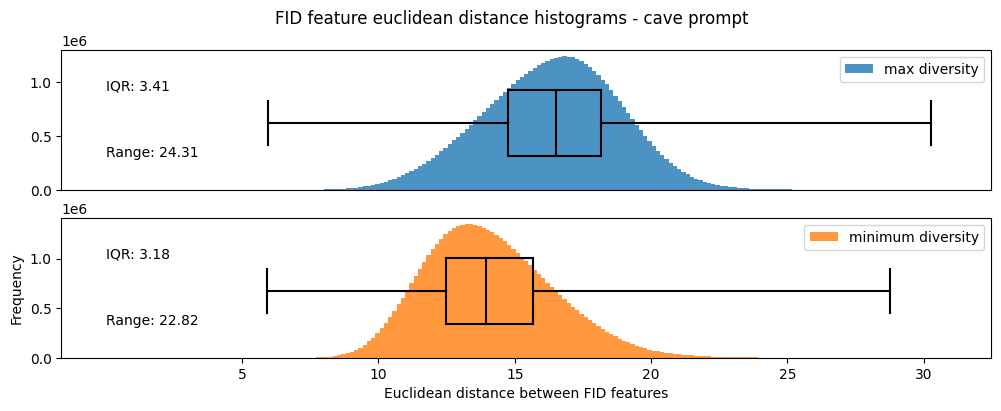

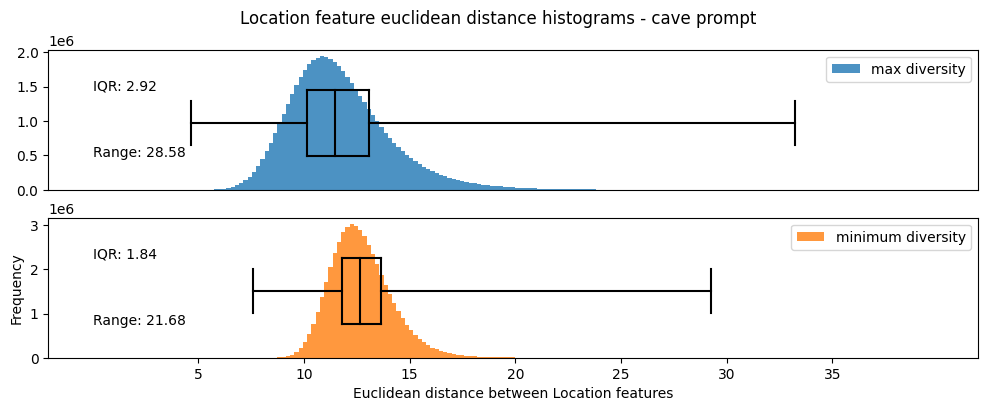

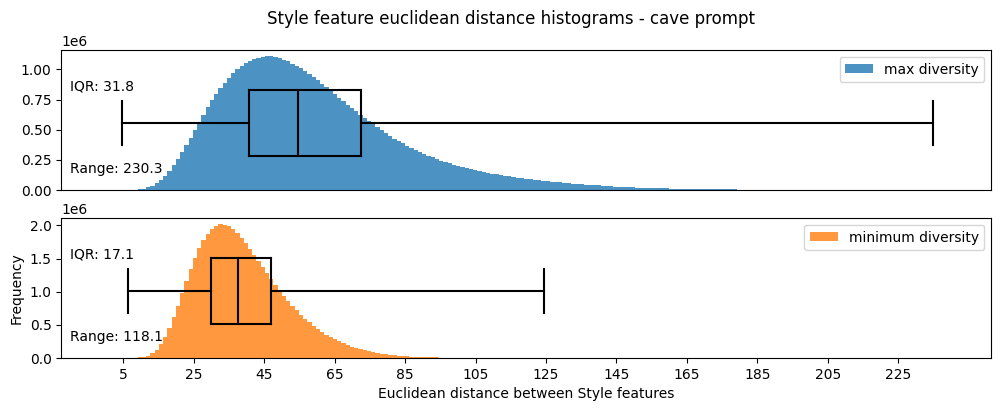

In [188]:
# H1 SEPARATE
exp_names_h1 = {
    'max_div': 'max diversity',
    'min_div':'minimum diversity'
}
subject='cave'
for m, met in enumerate(mets):
    met_name = met_names[m]
    n_bins = all_n_bins[subject, met]
    hists = all_hists[subject, met]

    plt.figure(figsize=(12,1*len(exp_names_h1)+2))
    colors = plt.rcParams["axes.prop_cycle"]()
    for i, exp in enumerate(exp_names_h1):
        plt.subplot(len(exp_names_h1),1,i+1)
        c = next(colors)["color"]
        if met=="stats":
            ubound=31
        elif met=="gram64":
            ubound=240
        elif met=="local":
            ubound=40
        bins = np.linspace(0,ubound, nbins)
        width = bins[1]-bins[0]
        plt.bar(bins[:-1],n_bins[exp],width=width, alpha=0.8, label=exp_names_h1[exp], color=c)

        # Plot statistics - box and whisker
        med = np.median(hists[exp])
        q100, q75, q25, q0 = np.percentile(hists[exp], [100, 75 ,25, 0])
        h = np.max(n_bins[exp])
        plt.plot(np.array([med]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q75]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q25]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q100]*2), [h/3,h*2/3], color='black')
        plt.plot(np.array([q0]*2), [h/3,h*2/3], color='black')
        plt.plot(np.array([q0,q25]), [h/2]*2, color='black')
        plt.plot(np.array([q75,q100]), [h/2]*2, color='black')
        plt.plot(np.array([q25,q75]), [h*3/4]*2, color='black')
        plt.plot(np.array([q25,q75]), [h/4]*2, color='black')
        range_val = q100-q0
        iqr_val = q75-q25
        if met=="gram64":
            xtext=-10
            plt.text(xtext,h*3/4, f"IQR: {iqr_val:.1f}")
            plt.text(xtext,h/8, f"Range: {range_val:.1f}")
        else:
            xtext = 0
            plt.text(xtext,h*3/4, f"IQR: {iqr_val:.2f}")
            plt.text(xtext,h/4, f"Range: {range_val:.2f}")
        ranges[subject, met, exp] = range_val
        iqrs[subject, met, exp] = iqr_val

        # plt.xlim([0,ubound])
        
        if i==len(exp_names_h1)//2:
            plt.ylabel('Frequency')
        plt.suptitle(f'Distance histogram - cave prompt')
        # if i!=len(exp_names_h1)-1:
        plt.xticks([])
        plt.legend(loc='upper right')
    if met=="stats":
        plt.xticks(np.arange(5,31,step=5))
    elif met=="gram64":
        plt.xticks(np.arange(5,240,step=20))
    elif met=="local":
        plt.xticks(np.arange(5,40,step=5))
    plt.xlabel(f'Euclidean distance between {met_name} features')
    plt.suptitle(f'{met_name} feature euclidean distance histograms - {subject} prompt')
    plt.savefig(f'data/final/plot_dist_hist/dist_hist_max_min_{subject}_{met}.pdf')

In [197]:
# plot dist hist averages
from collections import defaultdict
avg_iqr = defaultdict(float)
for a,b,c in ranges:
    avg_iqr[b,c] += ranges[a,b,c]
for val in avg_iqr:
    avg_iqr[val] = avg_iqr[val] / len(subjects)
    print(val, f"{avg_iqr[val]:.2f}")

('stats', 'max_div') 23.46
('stats', 'min_div') 21.49
('stats', 'langevin') 20.22
('stats', 'averagedim_all_r1000') 21.90
('stats', 'ro3_all_r1000') 21.84
('stats', 'cnn16_all_r1000') 20.77
('stats', 'vgg_noise_all_r1000') 22.15
('stats', 'vgg_noisero3_all_r1000') 23.12
('local', 'max_div') 41.50
('local', 'min_div') 25.53
('local', 'langevin') 25.09
('local', 'averagedim_all_r1000') 26.09
('local', 'ro3_all_r1000') 27.38
('local', 'cnn16_all_r1000') 27.44
('local', 'vgg_noise_all_r1000') 26.68
('local', 'vgg_noisero3_all_r1000') 26.97
('gram64', 'max_div') 275.73
('gram64', 'min_div') 161.29
('gram64', 'langevin') 211.14
('gram64', 'averagedim_all_r1000') 163.10
('gram64', 'ro3_all_r1000') 165.52
('gram64', 'cnn16_all_r1000') 200.45
('gram64', 'vgg_noise_all_r1000') 167.96
('gram64', 'vgg_noisero3_all_r1000') 154.56


In [194]:
# TODO: Plot iqrs and range values for all methods
for a,b,c in iqrs:
    print(a,b,c,f"{iqrs[a,b,c]:.2f}")

actress stats max_div 2.96
actress stats min_div 3.37
actress stats langevin 3.11
actress stats averagedim_all_r1000 3.45
actress stats ro3_all_r1000 3.24
actress stats cnn16_all_r1000 3.34
actress stats vgg_noise_all_r1000 3.50
actress stats vgg_noisero3_all_r1000 3.66
actress local max_div 4.23
actress local min_div 2.45
actress local langevin 2.20
actress local averagedim_all_r1000 2.54
actress local ro3_all_r1000 2.80
actress local cnn16_all_r1000 2.32
actress local vgg_noise_all_r1000 2.56
actress local vgg_noisero3_all_r1000 2.67
actress gram64 max_div 30.58
actress gram64 min_div 23.19
actress gram64 langevin 26.97
actress gram64 averagedim_all_r1000 23.86
actress gram64 ro3_all_r1000 21.53
actress gram64 cnn16_all_r1000 24.46
actress gram64 vgg_noise_all_r1000 23.18
actress gram64 vgg_noisero3_all_r1000 21.39
cave stats max_div 3.41
cave stats min_div 3.18
cave stats langevin 2.47
cave stats averagedim_all_r1000 3.07
cave stats ro3_all_r1000 3.08
cave stats cnn16_all_r1000 3.01

In [191]:
len(iqrs)

52

/tmp/ipykernel_980138/1726472684.py:10: RuntimeWarning: divide by zero encountered in log
  plt.bar(bins[:-1],np.log(n_bins[exp]),width=width, alpha=0.8, label=exp_names[exp], color=c)


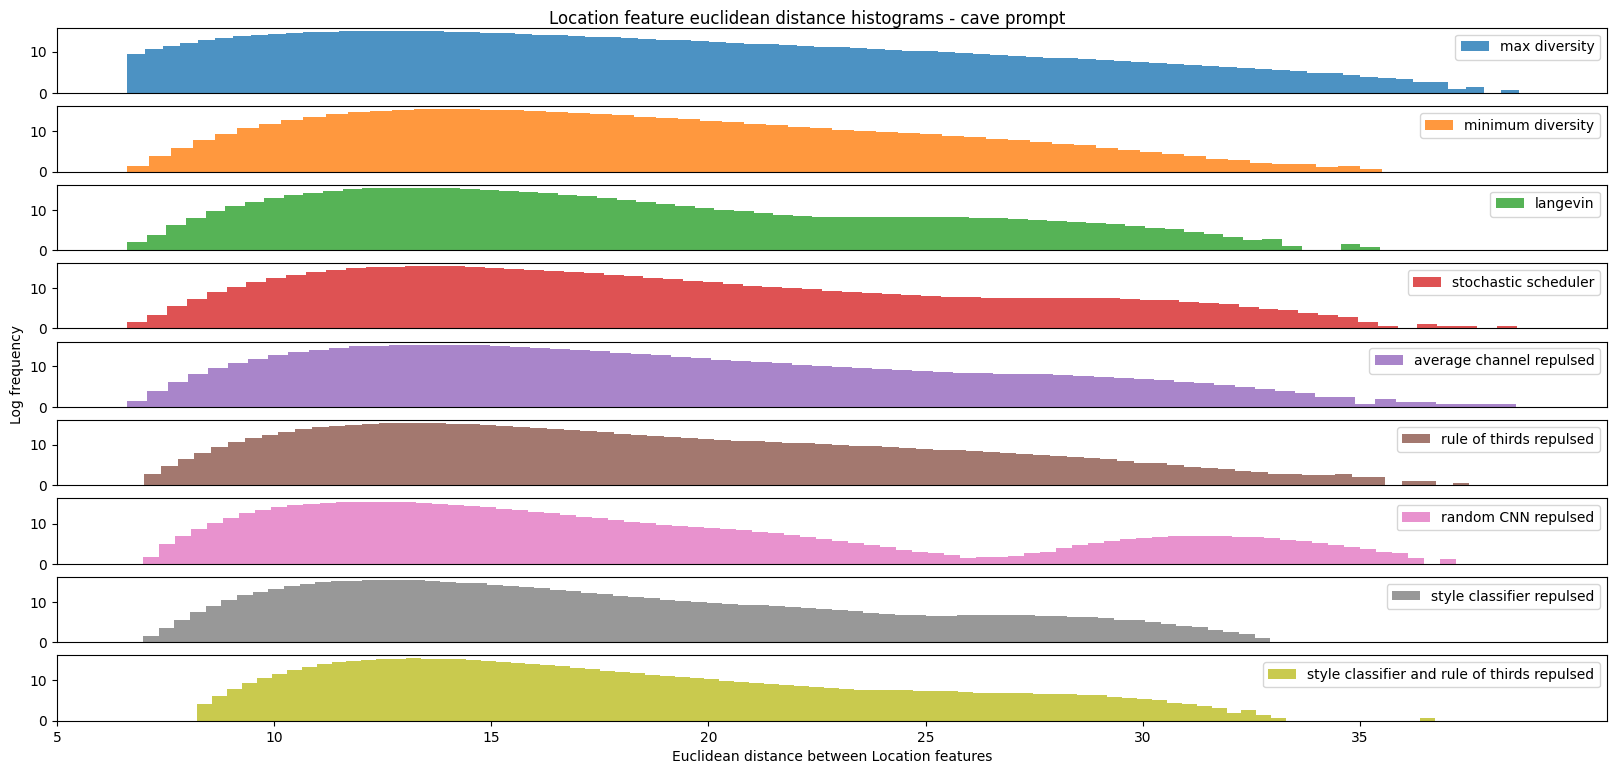

In [19]:
# LOG HISTOGRAM
plt.figure(figsize=(20,1*len(exp_names)))
colors = plt.rcParams["axes.prop_cycle"]()

# Can also plot log frequencies

for i, exp in enumerate(exp_names):
    plt.subplot(len(exp_names),1,i+1)
    c = next(colors)["color"]
    plt.bar(bins[:-1],np.log(n_bins[exp]),width=width, alpha=0.8, label=exp_names[exp], color=c)
    if i==len(exp_names)//2:
        plt.ylabel('Log frequency')
    plt.suptitle(f'Distance histogram - cave prompt')
    plt.xticks([])
    plt.legend()
if met=="stats":
    plt.xticks(np.arange(5,31,step=5))
elif met=="gram64":
    plt.xticks(np.arange(5,240,step=20))
elif met=="local":
    plt.xticks(np.arange(5,40,step=5))
plt.xlabel(f'Euclidean distance between {met_name} features')
plt.suptitle(f'{met_name} feature euclidean distance histograms - cave prompt',y=0.9)
plt.savefig(f'data/final/cave/plots/cave_hist_log_{met}.pdf')

In [ ]:
plt.figure(figsize=(20,5))
for exp in exp_names:
    plt.hist(hists[exp], label=exp_names[exp], **kwargs)
plt.legend()
plt.title(f'Distance histogram - cave prompt')
plt.xlabel(f'Euclidean distance between FID features')
plt.ylabel('Frequency')
plt.xlim(6,25)

In [ ]:
plt.figure(figsize=(20,5*len(exp_names)))

for i, exp in enumerate(exp_names):
    plt.subplot(len(exp_names),1,i+1)
    plt.hist(hists[exp], label=exp_names[exp], **kwargs)
    plt.xticks(np.arange(5,31,step=5))
    plt.xlabel(f'Euclidean distance between FID features')
    plt.ylabel('Frequency')
    plt.suptitle(f'Distance histogram - cave prompt')
    plt.legend()
plt.suptitle(f'FID feature euclidean distance histograms - cave prompt')

In [55]:
dst = f'data/final/cave/plots/min_div_stats_hist.pdf'
plt.savefig(dst)

<Figure size 640x480 with 0 Axes>

plots combining

In [132]:
# combining plots
from pypdf import PdfMerger
# exps = ['max_div','min_div','langevin','averagedim_all_r1000','ro3_all_r1000', 'cnn16_all_r1000','vgg_noise_all_r1000','vgg_noisero3_all_r1000']
exps = ['eulera']
subjects = ['actress','cave','kite','parkour','tree','vase']
for subject in subjects:
    for exp in exps:
        pdfs = [f'data/final/{subject}/plots/{exp}_stats_dists.pdf', 
                f'data/final/{subject}/plots/{exp}_local_dists.pdf', 
                f'data/final/{subject}/plots/{exp}_gram64_dists.pdf']

        merger = PdfMerger()

        for pdf in pdfs:
            merger.append(pdf)

        merger.write(f'data/final/{subject}/plots/{exp}_dists.pdf')
        merger.close()

In [ ]:
# combining plots
from pypdf import PdfMerger
pdfs = [f'data/final/plot_dist_hist/dist_hist_max_min_cave_stats.pdf', 
        f'data/final/data_hist_max_min_cave_local.pdf', 
        f'data/final/data_hist_max_min_cave_gram64.pdf']

merger = PdfMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write(f'data/final/data_hist_max_min_cave.pdf')
merger.close()

average pixel intensities

In [11]:
exps = ['max_div','min_div','langevin','averagedim_all_r1000','ro3_all_r1000', 'cnn16_all_r1000','vgg_noise_all_r1000','vgg_noisero3_all_r1000']
exp_names = {
    'max_div': 'max diversity',
    'min_div':'minimum diversity',
    'langevin': 'langevin',
    # 'eulera': 'stochastic scheduler',
    'averagedim_all_r1000': 'average channel repulsed',
    'ro3_all_r1000': 'rule of thirds repulsed',
    'cnn16_all_r1000':'random CNN repulsed',
    'vgg_noise_all_r1000':'style classifier repulsed',
    'vgg_noisero3_all_r1000':'style classifier and rule of thirds repulsed'
}
avgs = {}
for subject in ['actress','cave','kite','parkour','tree','vase']:
    for exp in exps:
        f = []
        if exp=="max_div":
            for file in glob(f"data/final/{subject}/{exp}/*/*.png"):
                f.append(file)
        else:
            for file in glob(f"data/final/{subject}/{exp}/all/*.png"):
                f.append(file)
        avg = []
        for file in f:
            img = plt.imread(file)
            avg.append(np.mean(img))
        avgs[subject, exp] = avg

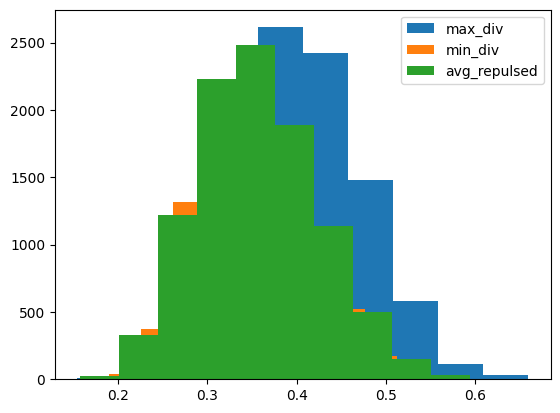

In [55]:
plt.hist(avg, label="max_div")
plt.hist(avg_min_div, label="min_div")
plt.hist(avg_r, label="avg_repulsed")
plt.legend()

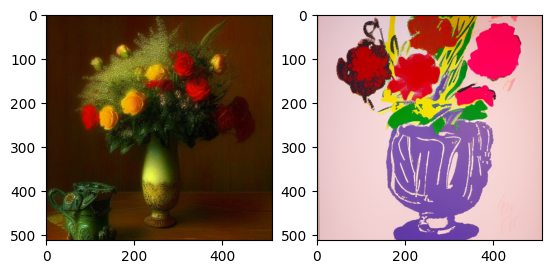

In [50]:
plt.subplot(1,2,1)
plt.imshow(plt.imread(f[np.argmin(avg)]))
plt.subplot(1,2,2)
plt.imshow(plt.imread(f[np.argmax(avg)]))

In [12]:
# pre-bin the data for averages
nbins= 200
bins = np.linspace(0,1, nbins)
width = bins[1]-bins[0]
subjects = ['actress','cave','kite','parkour','tree','vase']
n_bins = {}
for subject in subjects:
    for exp in exp_names:
        n, _ = np.histogram(avgs[subject, exp], bins=bins)
        n_bins[subject, exp] = n

In [ ]:
ranges = {}
iqrs = {}
# Can also plot log frequencies
# subject = "kite"
for subject in subjects:
    plt.figure(figsize=(15,1*len(exp_names)))
    colors = plt.rcParams["axes.prop_cycle"]()
    for i, exp in enumerate(exp_names):
        plt.subplot(len(exp_names),1,i+1)
        c = next(colors)["color"]
        plt.bar(bins[:-1],n_bins[subject, exp],width=width, alpha=0.8, label=exp_names[exp], color=c)

        # Plot statistics - box and whisker
        med = np.median(avgs[subject, exp])
        q100, q75, q25, q0 = np.percentile(avgs[subject, exp], [100, 75 ,25, 0])
        h = np.max(n_bins[subject, exp])
        plt.plot(np.array([med]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q75]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q25]*2), [h/4,h*3/4], color='black')
        plt.plot(np.array([q100]*2), [h/3,h*2/3], color='black')
        plt.plot(np.array([q0]*2), [h/3,h*2/3], color='black')
        plt.plot(np.array([q0,q25]), [h/2]*2, color='black')
        plt.plot(np.array([q75,q100]), [h/2]*2, color='black')
        plt.plot(np.array([q25,q75]), [h*3/4]*2, color='black')
        plt.plot(np.array([q25,q75]), [h/4]*2, color='black')
        range_val = q100-q0
        iqr_val = q75-q25
        plt.text(0,100, f"Range: {range_val:.3f}")
        plt.text(0,220, f"IQR: {iqr_val:.3f}")
        ranges[subject, exp] = range_val
        iqrs[subject, exp] = iqr_val

        
        if i==len(exp_names)//2:
            plt.ylabel('Frequency')
        plt.suptitle(f'Average histogram - {subject} prompt')
        plt.xticks([])
        plt.legend()
    plt.xlabel(f'Average pixel intensities')
    plt.suptitle(f'Average pixel intensity - {subject} prompt',y=0.91)
    plt.savefig(f'data/final/{subject}/plots/hist_avg_{subject}.pdf')

In [140]:
# Average iqr and range over the prompts
iqr_avg = {}
range_avg = {}
for exp in exps:
    total_iqr = 0
    total_range = 0
    for subject in subjects:
        total_iqr += iqrs[subject, exp]
        total_range += ranges[subject, exp]
    iqr_avg[exp] = total_iqr / len(subjects)
    range_avg[exp] = total_range / len(subjects)


In [142]:
range_avg


{'max_div': 0.4909841902554035,
 'min_div': 0.39369145035743713,
 'langevin': 0.42948360244433087,
 'averagedim_all_r1000': 0.45664190500974655,
 'ro3_all_r1000': 0.372543844083945,
 'cnn16_all_r1000': 0.40167249242464703,
 'vgg_noise_all_r1000': 0.4350520844260852,
 'vgg_noisero3_all_r1000': 0.4031417965888977}

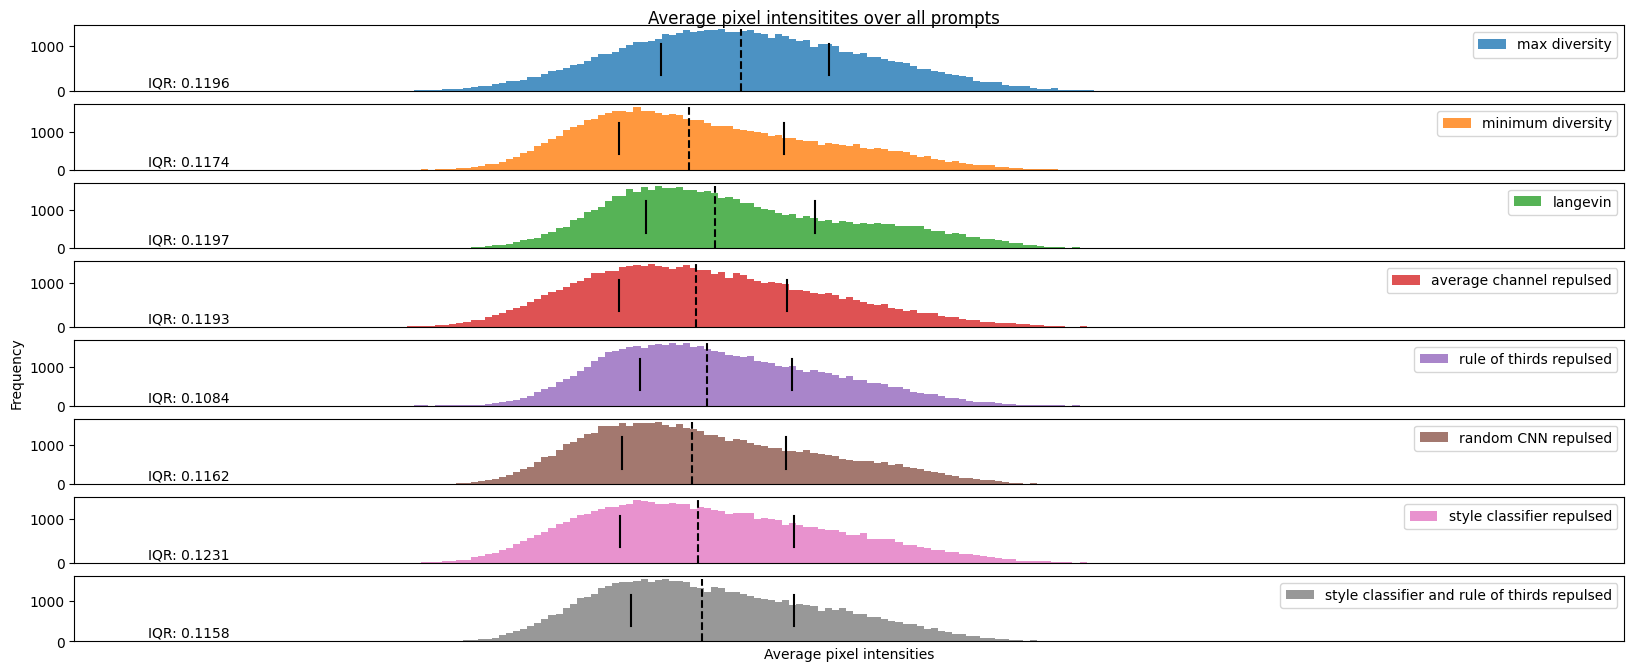

In [113]:
# IGNORE - Average pixel intensity histograms - Sum over all prompts wiht average histograms
plt.figure(figsize=(20,1*len(exp_names)))
colors = plt.rcParams["axes.prop_cycle"]()

# Can also plot log frequencies
# subject = "actress"
for i, exp in enumerate(exp_names):
    total_n_bins = []
    total_avgs = []
    for subject in subjects:
        total_n_bins.append(n_bins[subject, exp])
        total_avgs = np.concatenate((total_avgs, avgs[subject, exp]))
    
    total_n_bins = np.sum(np.array(total_n_bins),axis=0)
    
    plt.subplot(len(exp_names),1,i+1)
    c = next(colors)["color"]
    plt.bar(bins[:-1],total_n_bins,width=width, alpha=0.8, label=exp_names[exp], color=c)

    # Plot statistics
    med = np.median(total_avgs)
    q75, q25 = np.percentile(total_avgs, [75 ,25])
    h = np.max(total_n_bins)
    plt.plot(np.array([med]*2), [0,h], '--', color='black')
    plt.plot(np.array([q75]*2), [h/4,h*3/4], color='black')
    plt.plot(np.array([q25]*2), [h/4,h*3/4], color='black')
    plt.text(0,100, f"IQR: {str(round(q75-q25,4))}")
    # TODO: Write down median as well - possibly quartiles as well on plot

    
    if i==len(exp_names)//2:
        plt.ylabel('Frequency')
    plt.suptitle(f'Average histogram - {subject} prompt')
    plt.xticks([])
    plt.legend()
plt.xlabel(f'Average pixel intensities')
plt.suptitle(f'Average pixel intensitites over all prompts',y=0.9)
plt.savefig(f'data/final/hist_avg.pdf')

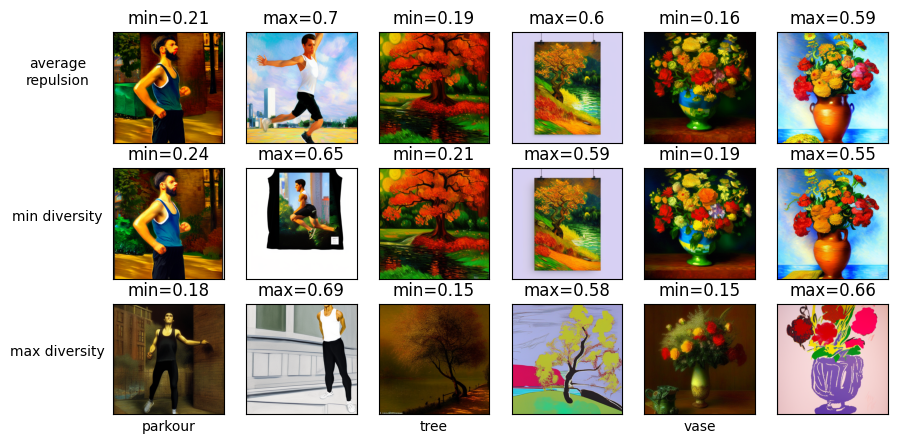

In [111]:
# PLOTTING DARKEST AND LIGHTEST IMAGES
plt.figure(figsize=(10,5))
avg_exps = ['averagedim_all_r1000','min_div','max_div']
avg_exp_names = ['average\nrepulsion', 'min diversity', 'max diversity']
nrows = len(avg_exps)
ncols = len(subjects)
for j, subject in enumerate(subjects[3:]):
    for i, exp in enumerate(avg_exps):
        f = []
        if exp=="max_div":
            for file in glob(f"data/final/{subject}/{exp}/*/*.png"):
                f.append(file)
        else:
            for file in glob(f"data/final/{subject}/{exp}/all/*.png"):
                f.append(file)

        # plt.subplot(nrows,ncols,(i+1,2*j+1))
        ax = plt.subplot(nrows,ncols,2*j+1 + ncols*i)
        plt.yticks([])
        plt.xticks([])
        if j==0:
            plt.ylabel(avg_exp_names[i], rotation=0, labelpad=40)
        if i==nrows-1:
            # Move it right
            plt.xlabel(subject)

        plt.imshow(plt.imread(f[np.argmin(avgs[subject, exp])]))
        plt.title(f'min={str(round(np.min(avgs[subject, exp]),2))}')
        
        # plt.subplot(nrows,ncols,(i+1,2*j+2))
        plt.subplot(nrows,ncols,2*j+2 + ncols*i)
        plt.yticks([])
        plt.xticks([])
        plt.title(f'max={str(round(np.max(avgs[subject, exp]),2))}')
        plt.imshow(plt.imread(f[np.argmax(avgs[subject, exp])]))
        # if i==nrows-1:
        #     # hack to get centre text
        #     plt.ylabel(subject, rotation=0, loc="bottom", fontsize=20,labelpad=5)
    # plt.suptitle('Darkest and lightest images - Average pixel intensities')
    plt.savefig('data/final/extreme_avg_2.pdf')

Repulsed image plots for report - done in metrics_2.ipynb

In [3]:
subject='tree'
method = 'averagedim'
base = f'data/report_results/{subject}/{subject}_r0.png'
files = [base] + glob(f'data/report_results/{subject}/{method}/*')

In [4]:
files

['data/report_results/tree/tree_r0.png',
 'data/report_results/tree/averagedim/averagedim_r100.png',
 'data/report_results/tree/averagedim/averagedim_r200.png',
 'data/report_results/tree/averagedim/averagedim_r300.png',
 'data/report_results/tree/averagedim/averagedim_r400.png']